$\LaTeX$ definitions:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
from astropy.cosmology import Planck15
import astropy.cosmology as cosmo
import astropy.units as u
import corner
import pystan
import seaborn as sns

In [3]:
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

This is a very simple cosmology fitter using Stan's ODE solver function to compute luminosity distances and fit for a density parameters and H0.  Recall that the "curvature density" (not a physical density) is 
$$
\Omega_k \equiv 1 - \sum_i \Omega_i,
$$
where the $\Omega_i$ are the dimensionless densities of matter, dark energy, radiation, etc.

The luminosity distance is given by ([Hogg, 1999](http://adsabs.harvard.edu/cgi-bin/nph-data_query?bibcode=1999astro.ph..5116H&link_type=ABSTRACT))
$$
D_L(z) = \left(1+z\right) D_M(z),
$$
where $D_M$ is the transverse comoving distance, 
$$
D_M(z) = \begin{cases}
\frac{D_H}{\sqrt{\Omega_k}} \sinh \left( \sqrt{\Omega_k} \frac{D_C(z)}{D_H} \right) & \Omega_k > 0 \\
D_C(z) & \Omega_k = 0 \\
\frac{D_H}{\sqrt{-\Omega_k}} \sin \left( \sqrt{-\Omega_k} \frac{D_C(z)}{D_H} \right) & \Omega_k < 0
\end{cases}.
$$
For a universe that contains matter and a cosmological constant, the line of sight comoving distance $D_C$ is  
$$
D_C(z) = D_H \int_0^{z} \dd z \, \frac{1}{\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda + \Omega_k \left( 1 + z \right)^2}}.
$$
The Hubble distance is 
$$
D_H \equiv \frac{c}{H_0}. 
$$
The integral above, $I(z)$, with 
$$
I(z) = \int_0^{z} \dd z \, \frac{1}{\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda + \Omega_k \left( 1 + z \right)^2}},
$$
satisfies the differential equation 
$$
\diff{I}{z} = \frac{1}{\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda + \Omega_k \left( 1 + z \right)^2}},
$$
with initial condition
$$
I(0) = 0.
$$
These are the equations we will feed to Stan's `ode_integrate_rk45` function.

First, we generate some mock data with (known) Gaussian uncertainty of 10% in the luminosity distance.

In [4]:
H0 = Planck15.H0.to(u.km/u.s/u.Mpc).value
Om = Planck15.Om0
Ol = Planck15.Ode0

my_cosmo = Planck15

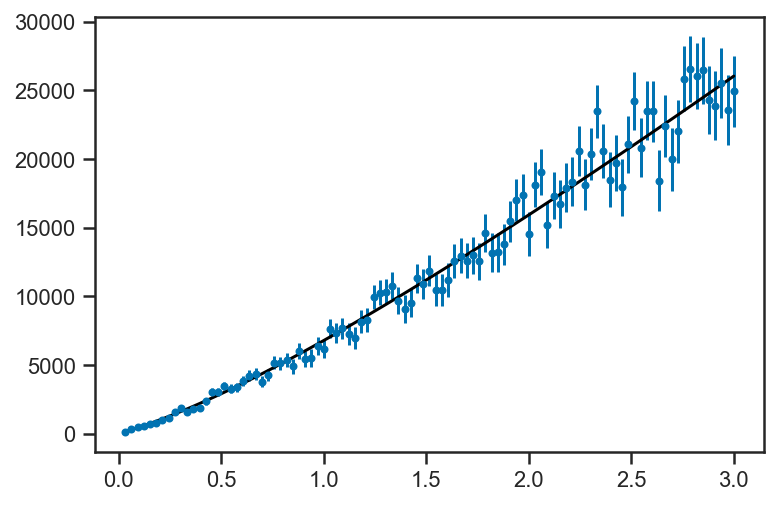

In [5]:
zs = linspace(0, 3, 100)
zs = zs[1:] # We don't want z = 0
dls_true = my_cosmo.luminosity_distance(zs).to(u.Mpc).value
sigma_dls = 0.1*dls_true
dls_obs = dls_true + sigma_dls*randn(dls_true.shape[0])

errorbar(zs, dls_obs, sigma_dls, fmt='.')
plot(zs, dls_true, '-k')

Now we compile the Stan model, and run the fit.  Note the `control` parameter, where we specify that Stan should use a "dense" mass matrix; this means that it will learn the correlations between the cosmological parameters during the warmup phase and use them to choose momenta that are aligned with the pricipal axes of the posterior.

In [7]:
model = pystan.StanModel(file='cosmography.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0cae7b33eefabaa98a8541021bceb6b8 NOW.


In [8]:
cosmography_data = {'Nobs': zs.shape[0],
                    'dls_obs': dls_obs,
                    'sigma_dls_obs': sigma_dls,
                    'zobs': zs}

thin = 1

fit = model.sampling(data=cosmography_data, thin=thin, iter=2000*thin, control={'metric': 'dense_e'})
fit = az.convert_to_inference_data(fit)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9550b3a810>,
      dtype=object)

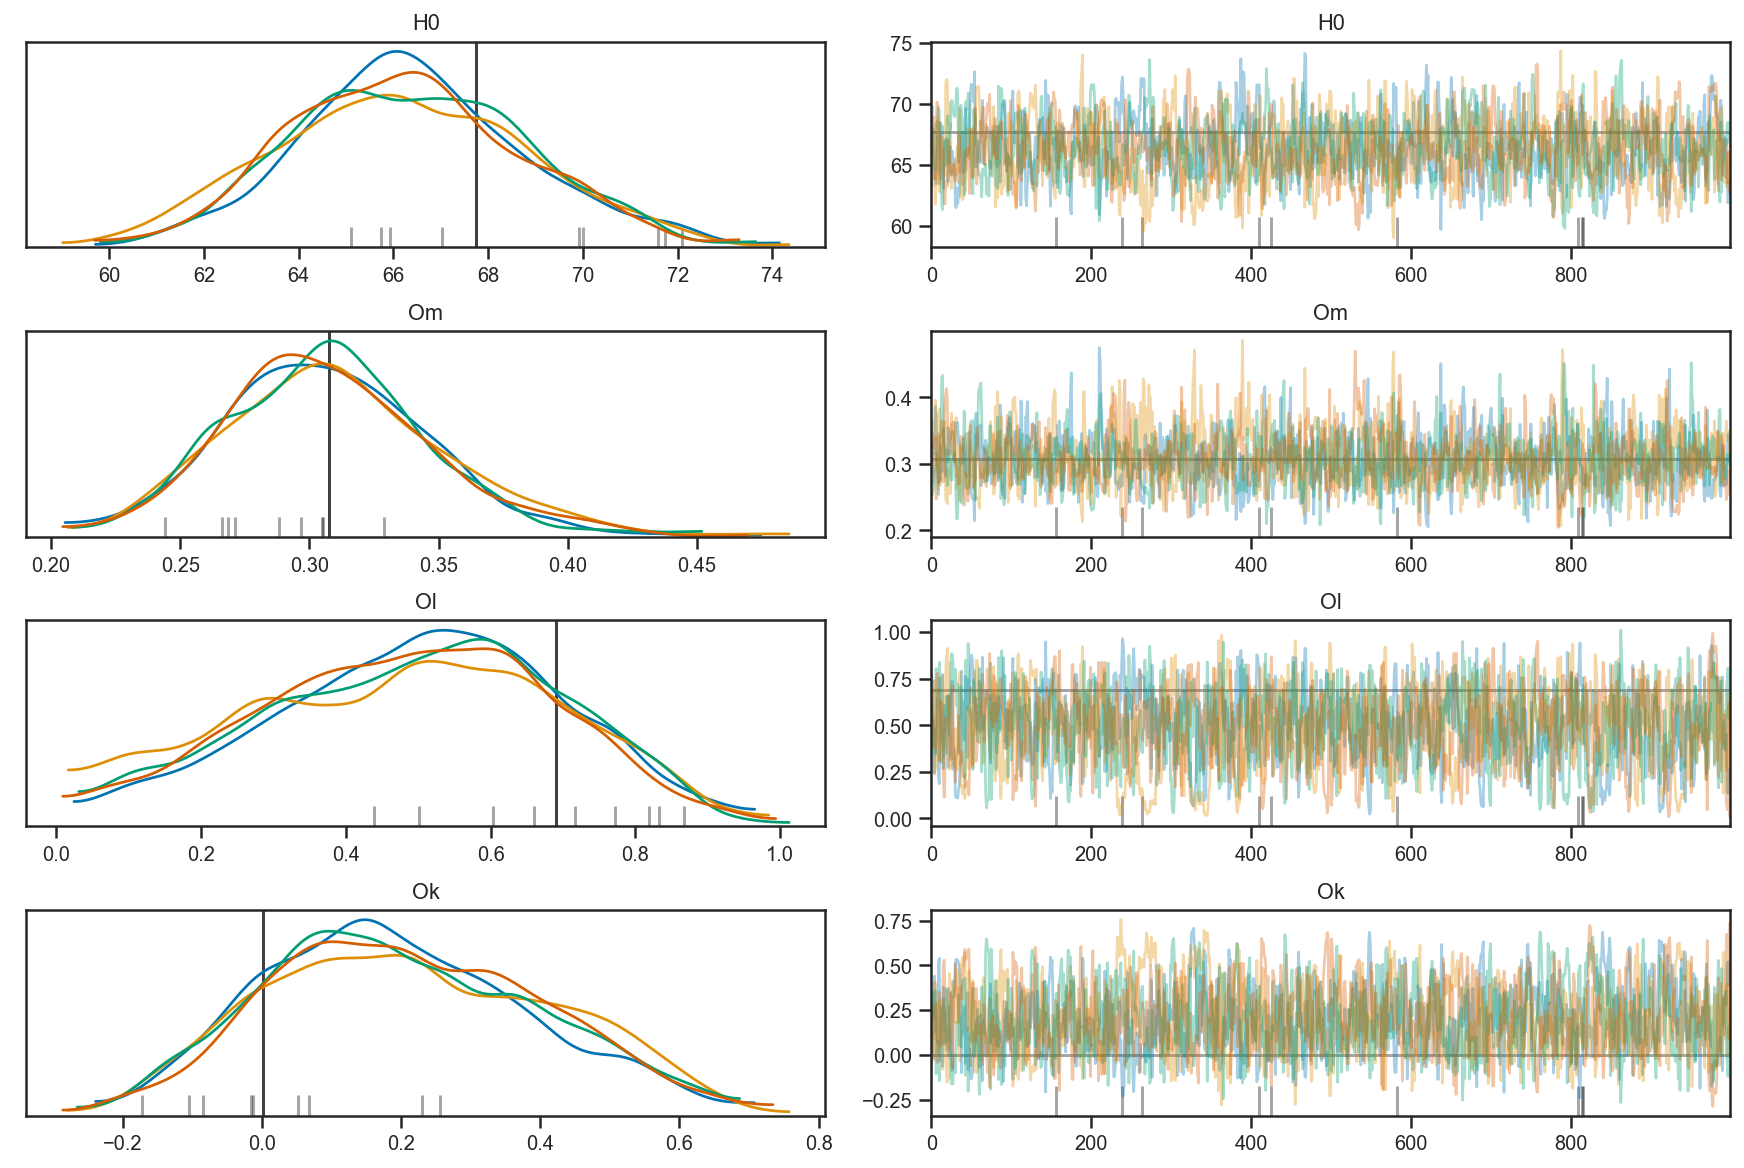

In [10]:
az.plot_trace(fit, var_names=['H0', 'Om', 'Ol', 'Ok'], lines=(('H0', {}, H0),
                                                              ('Om', {}, Om),
                                                              ('Ol', {}, Ol),
                                                              ('Ok', {}, 1 - Om - Ol)))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95523eec50>,
      dtype=object)

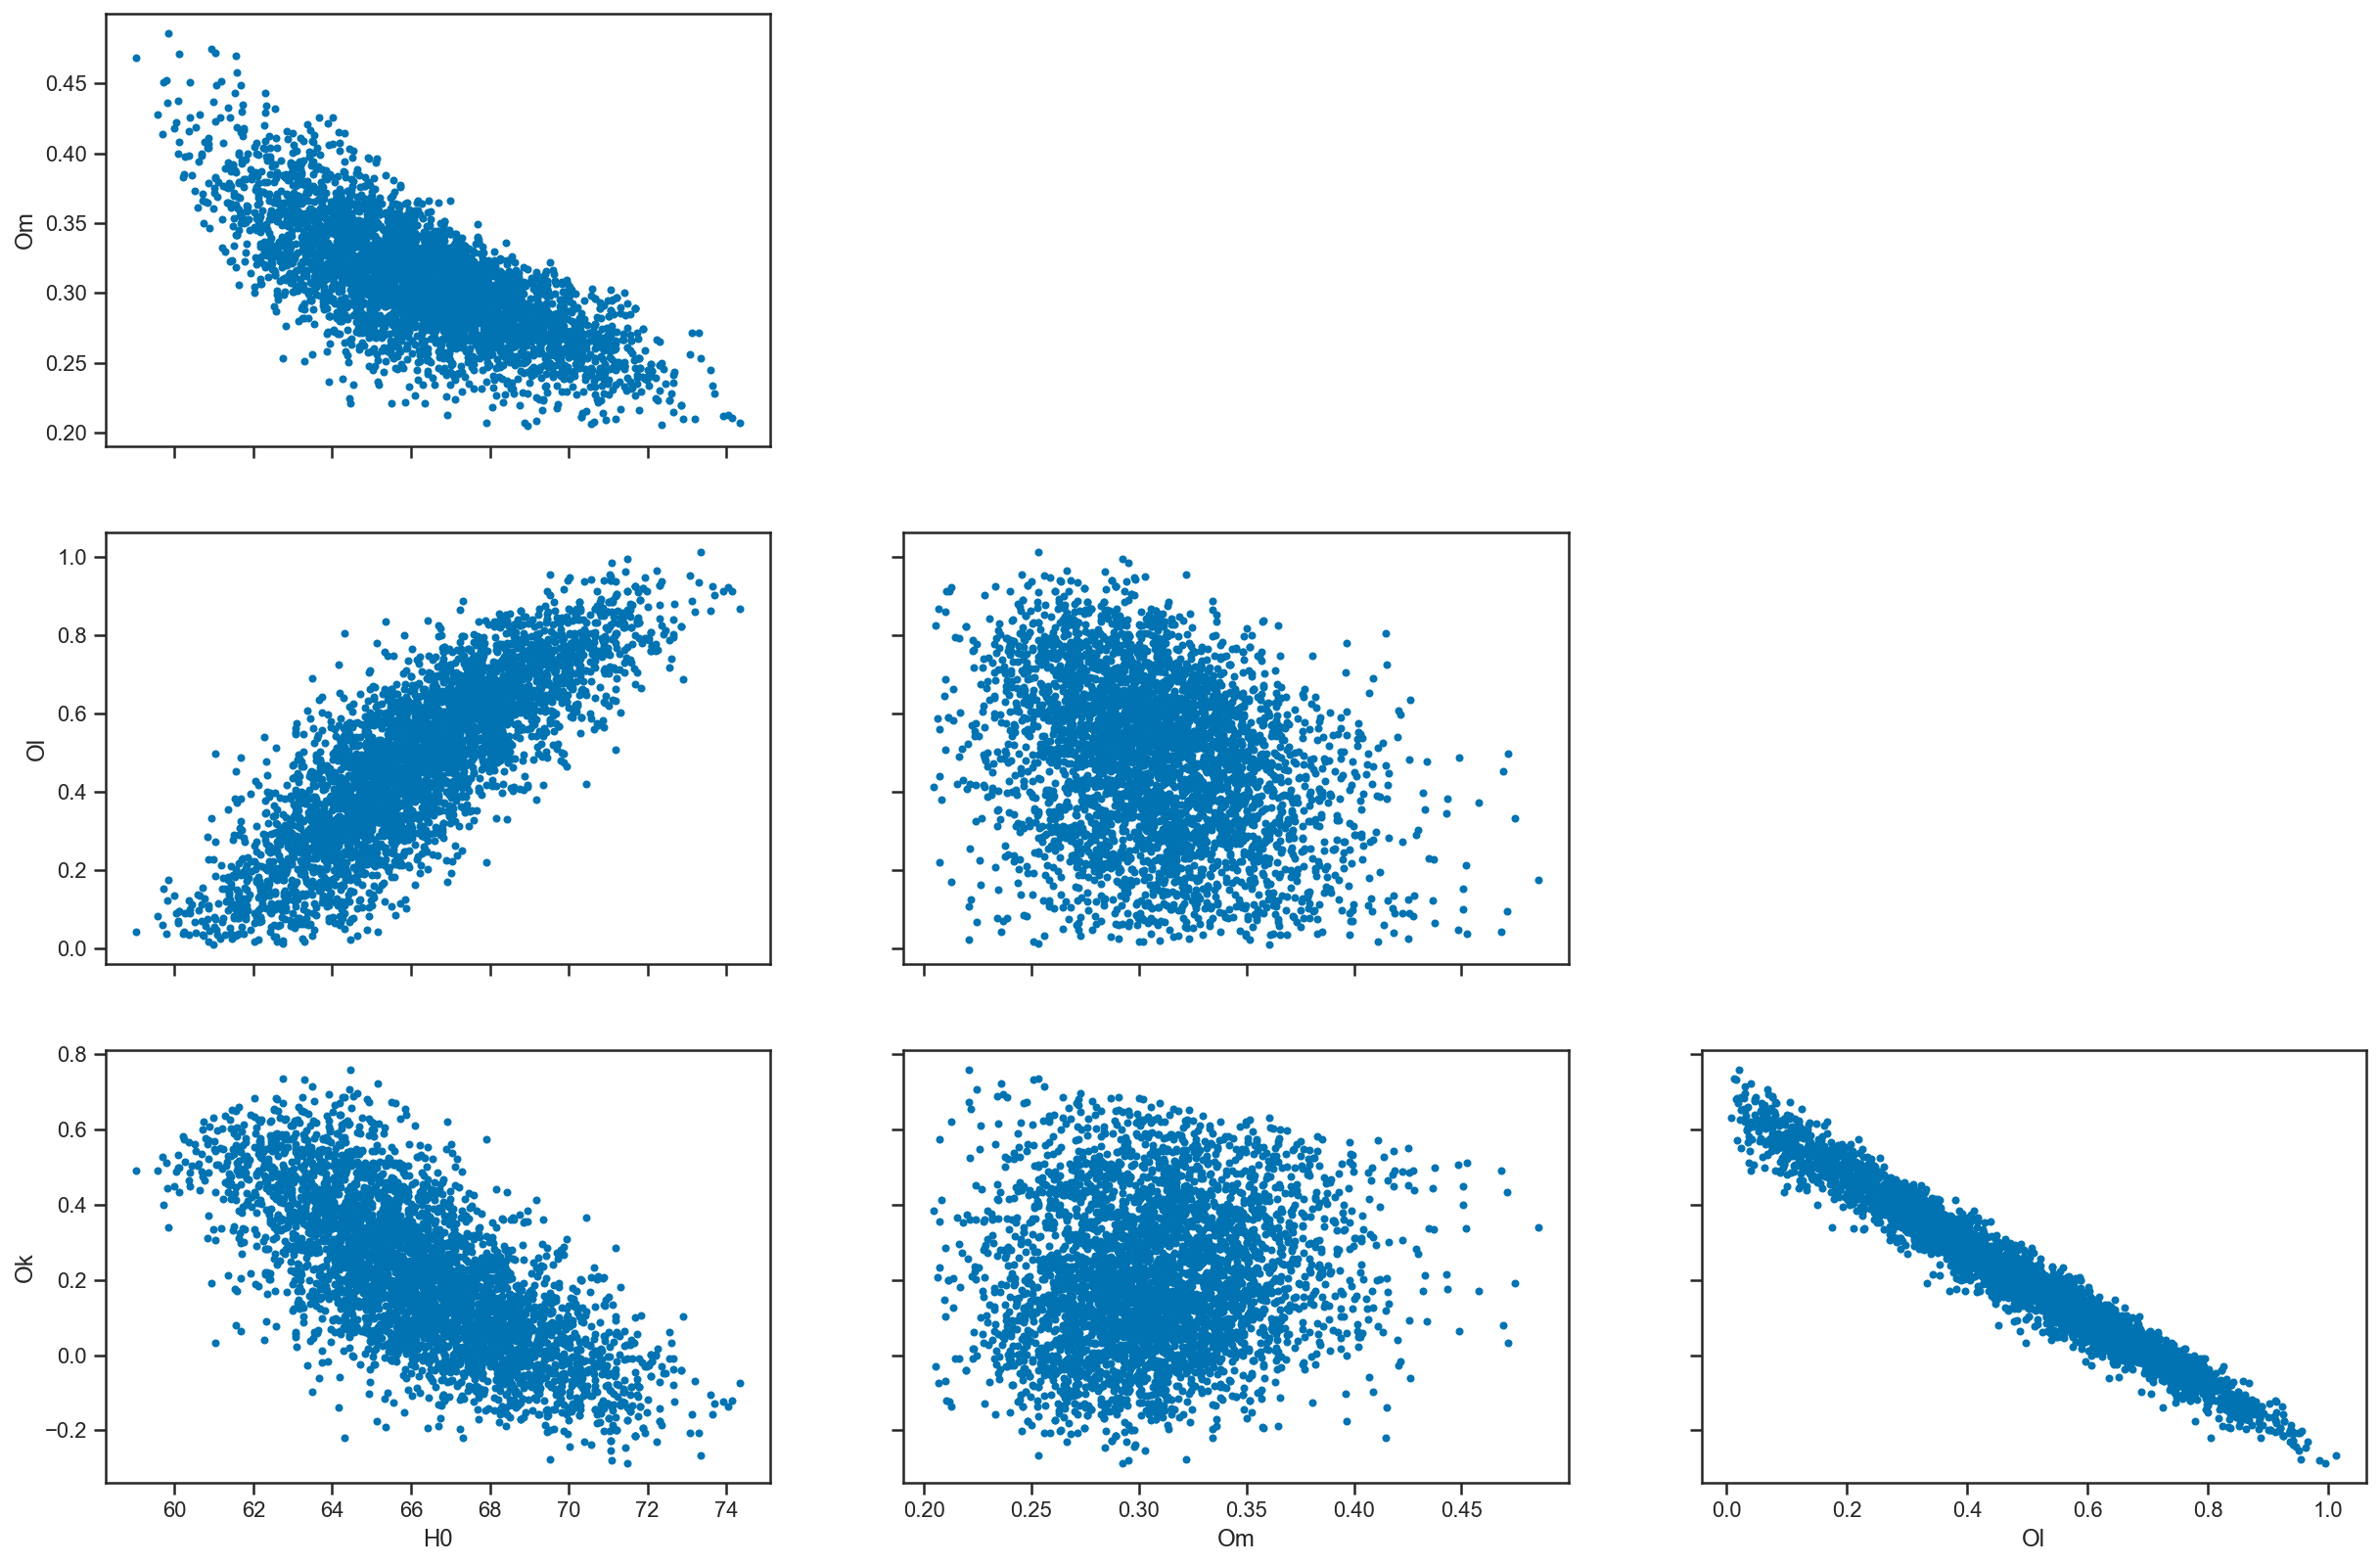

In [12]:
az.plot_pair(fit, var_names=['H0', 'Om', 'Ol', 'Ok'])

And, since we don't have any peculiar motion, or other measurement errors on the redshifts, we have really built a hierarchical, cosmological model of distance.  The plot below shows the data, the true redshift-distance relation, and the inferred distances of each object once we have fit the cosmology.  The posterior distance estimates have such tiny uncertainty because we do not have any uncertainty in the redshift, and we assume that the cosmological relation perfectly maps redshift to distance; the only remaining source of uncertainty comes from the cosmological parameters, and that is tiny.

Text(0, 0.5, '$d_L(z)$')

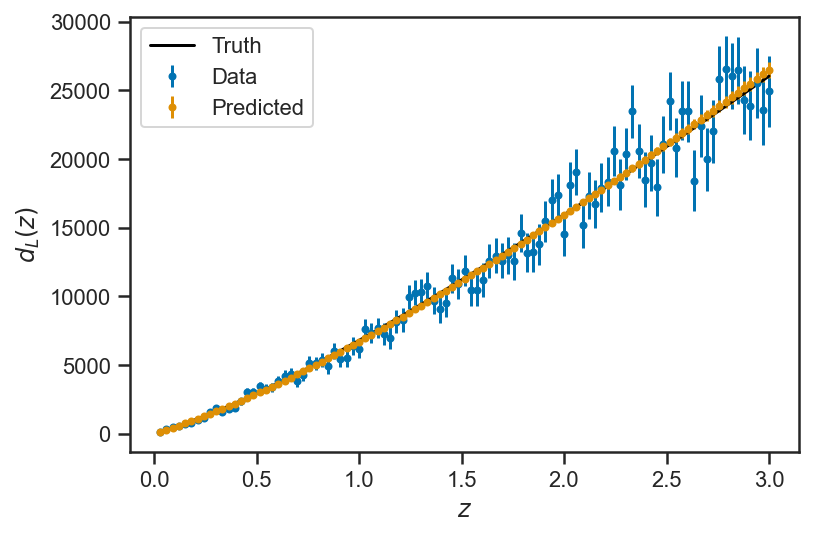

In [13]:
errorbar(zs, dls_obs, sigma_dls, fmt='.', label='Data')
errorbar(zs, mean(fit.posterior['dls_pred'], axis=(0,1)), std(fit.posterior['dls_pred'], axis=(0,1)), fmt='.', label='Predicted')
plot(zs, dls_true, '-k', label='Truth')
legend(loc='best')
xlabel(r'$z$')
ylabel(r'$d_L(z)$')